In [1]:
# Importing Necesaary Library
import scipy.io
import math
import numpy as np
import sys
import timeit

import copy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

from skimage.transform import rotate
import scipy.fftpack as fft
from skimage.transform import rotate

from skimage.transform import radon, rescale, iradon
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

Loading CT Scans

In [2]:
data = scipy.io.loadmat("./ctscan_hw1.mat")
temp_ct_scans = data['ctscan']
ct_scans = []
for i in range(temp_ct_scans.shape[2]):
  ct_scans.append(temp_ct_scans[:,:,i])
ct_scans = np.array(ct_scans)
print(ct_scans.shape)

(3554, 512, 512)


Loading Infection Masks

In [3]:
data = scipy.io.loadmat("./infmsk_hw1.mat")
infmask = data['infmsk']
infection_masks = []
for i in range(infmask.shape[2]):
  infection_masks.append(infmask[:,:,i])
infection_masks = np.array(infection_masks)
print(infection_masks.shape)

N = ct_scans.shape[0]

(3554, 512, 512)


# Part B, Functions

Functions to correct predicted mask, i.e., correct background, infection and healthy region as expected

In [4]:
def find_counts(mask):
  count_background = np.count_nonzero(mask == 0)
  count_infection = np.count_nonzero(mask == 1)
  count_healthy = np.count_nonzero(mask == 2)
  return np.array([count_background, count_infection, count_healthy])

def check_pred_mask(pred_mask):
  pred_count_list = find_counts(pred_mask)
  original_count_list = np.array([100,10,50])
  mapping = dict({})

  for i in range(3):
    pred_max_idx = np.argmax(pred_count_list)
    original_max_idx = np.argmax(original_count_list)
    mapping[pred_max_idx] = original_max_idx
    pred_count_list[pred_max_idx] = -1
    original_count_list[original_max_idx] = -1

  corrected_mask = np.empty(shape=(512,512), dtype=int)
  for i in range(512):
    for j in range(512):
      corrected_mask[i][j] = mapping[pred_mask[i][j]]

  return corrected_mask

Function for printing two sample slices

In [5]:
def print_two_sample_slices(pred_masks, ct_scans):
  plt.rcParams["figure.figsize"] = (12,12)
  i = 99
  f, axarr = plt.subplots(1,3)
  axarr[0].set_title("Expert Annotations")
  axarr[0].imshow(infection_masks[i], cmap='gray')
  axarr[1].set_title("Predicted Masks")
  axarr[1].imshow(pred_masks[i], cmap='gray')
  axarr[2].set_title("Reconstructed CT Scans")
  axarr[2].imshow(ct_scans[i], cmap='gray')
  f.tight_layout()
  plt.show()

  i = 69
  f, axarr = plt.subplots(1,3)
  axarr[0].set_title("Expert Annotations")
  axarr[0].imshow(infection_masks[i], cmap='gray')
  axarr[1].set_title("Predicted Masks")
  axarr[1].imshow(pred_masks[i], cmap='gray')
  axarr[2].set_title("CT Scans")
  axarr[2].imshow(ct_scans[i], cmap='gray')
  f.tight_layout()
  plt.show()

Using k-means for Image Segmentation

In [6]:
def get_predicted_mask(ct_scans):
  start = timeit.default_timer()

  pred_masks = []
  N = len(ct_scans)
  for i in range(N):
    sys.stdout.write('\r'+"Processing Image "+str(i))
    sample = ct_scans[i]
    kmeans_obj = KMeans(n_clusters=3, random_state=0)
    ct_scan_flattened = sample.flatten().reshape((512*512,1))
    clusters = kmeans_obj.fit_predict(ct_scan_flattened)
    curr_pred_mask = clusters.reshape((512,512))
    curr_pred_mask = check_pred_mask(curr_pred_mask)
    pred_masks.append(curr_pred_mask)

  pred_masks = np.array(pred_masks)

  stop = timeit.default_timer()
  print('Time Taken = ', stop - start) 
  
  print_two_sample_slices(pred_masks, ct_scans)
  return pred_masks

Evaluating the model performance using several evaluation metrics

In [7]:
def get_confusion_metric(true_y, pred_y):
  true_y = true_y.flatten()
  pred_y = pred_y.flatten()
  return confusion_matrix(true_y, pred_y,labels=[0,1,2])
  
def get_req_avg_eval_metrics(infection_masks, pred_masks):
  
  avg_infection_sensitivity = 0
  avg_infection_specificity = 0
  avg_infection_accuracy = 0
  avg_infection_dice_score = 0
  
  avg_healthy_sensitivity = 0
  avg_healthy_specificity = 0
  avg_healthy_accuracy = 0
  avg_healthy_dice_score = 0

  count_infection_sensitivity = 0               # nan error
  count_healthy_sensitivity = 0               # nan error

  N = len(pred_masks)
  for i in range(N):
    
    curr_confusion_metric = (get_confusion_metric(infection_masks[i],pred_masks[i])).T
    
    infection_TP = curr_confusion_metric[1][1]
    infection_TN = curr_confusion_metric[0][0] + curr_confusion_metric[2][0] + curr_confusion_metric[0][2] + curr_confusion_metric[2][2]
    infection_FP = curr_confusion_metric[1][0] + curr_confusion_metric[1][2] 
    infection_FN = curr_confusion_metric[0][1] + curr_confusion_metric[2][1]

    healthy_TP = curr_confusion_metric[2][2]
    healthy_TN = curr_confusion_metric[0][0] + curr_confusion_metric[0][1] + curr_confusion_metric[1][0] + curr_confusion_metric[1][1]
    healthy_FP = curr_confusion_metric[2][0] + curr_confusion_metric[2][1] 
    healthy_FN = curr_confusion_metric[0][2] + curr_confusion_metric[1][2]

    # Sensitivity = Recall = TP/(TP+FN)
    # Preicision = TP/(TP+FP)
    # Specificity = TN/(TN+FP)
    # Dice Score = 2.TP / (2.TP + FP + FN)

    infection_sensitivity = 0
    if((infection_TP+infection_FN)!=0):
      count_infection_sensitivity += 1
      infection_sensitivity = (infection_TP)/(infection_TP+infection_FN)
        
    infection_specificity = (infection_TN)/(infection_TN+infection_FP)
    infection_accuracy = (infection_TP+infection_TN)/(infection_TP+infection_TN+infection_FP+infection_FN)
    infection_dice_score = (2*infection_TP)/(2*infection_TP + infection_FP + infection_FN)

    healthy_sensitivity = 0
    if((healthy_TP+healthy_FN)!=0):
      count_healthy_sensitivity += 1
      healthy_sensitivity = (healthy_TP)/(healthy_TP+healthy_FN)
    
    healthy_specificity = (healthy_TN)/(healthy_TN+healthy_FP)
    healthy_accuracy = (healthy_TP+healthy_TN)/(healthy_TP+healthy_TN+healthy_FP+healthy_FN)
    healthy_dice_score = (2*healthy_TP)/(2*healthy_TP + healthy_FP + healthy_FN)

    avg_infection_sensitivity += infection_sensitivity
    avg_infection_specificity += infection_specificity
    avg_infection_accuracy += infection_accuracy
    avg_infection_dice_score += infection_dice_score

    avg_healthy_sensitivity += healthy_sensitivity
    avg_healthy_specificity += healthy_specificity
    avg_healthy_accuracy += healthy_accuracy
    avg_healthy_dice_score += healthy_dice_score

  avg_infection_sensitivity = avg_infection_sensitivity/count_infection_sensitivity
  avg_infection_specificity = avg_infection_specificity/N
  avg_infection_accuracy = avg_infection_accuracy/N
  avg_infection_dice_score = avg_infection_dice_score/N
  
  avg_healthy_sensitivity = 0
  if(count_healthy_sensitivity != 0):
    avg_healthy_sensitivity = avg_healthy_sensitivity/count_healthy_sensitivity
  avg_healthy_specificity = avg_healthy_specificity/N
  avg_healthy_accuracy = avg_healthy_accuracy/N
  avg_healthy_dice_score = avg_healthy_dice_score/N

  return avg_infection_dice_score, avg_infection_sensitivity, avg_infection_specificity, avg_infection_accuracy, avg_healthy_dice_score, avg_healthy_sensitivity, avg_healthy_specificity, avg_healthy_accuracy

In [8]:
def find_eval_metrics(infection_masks, pred_masks):
  inf_ds, inf_sen, inf_spec, inf_acc, hea_ds, hea_sen, hea_spec, hea_acc = get_req_avg_eval_metrics(infection_masks, pred_masks)
  print("Average Dice Score for Infection: ", inf_ds)
  print("Average Sensitivity for Infection: ", inf_sen)
  print("Average Specificity for Infection: ", inf_spec)
  print("Average Accuracy for Infection: ", inf_acc)
  print()
  print("Average Dice Score for Healthy: ", hea_ds)
  print("Average Sensitivity for Healthy: ", hea_sen)
  print("Average Specificity for Healthy: ", hea_spec)
  print("Average Accuracy for Healthy: ", hea_acc)

# Part C, Reconstruction

In [9]:
class reconstruction_sinogram:
  def __init__(self, ct_scans):
    self.ct_scans = ct_scans
    self.sinograms = []
    self.reconstructed_ct_scans = []
    
  def get_sinogram(self, ct_scan):
    return radon(ct_scan, circle = False, preserve_range = True)

  def ct_scans_to_sinograms(self):
    N = len(self.ct_scans)
    print("CT Scans -> Sinogram")
    for i in range(N):
      sys.stdout.write('\r'+"Image No. "+str(i))
      self.sinograms.append(self.get_sinogram(self.ct_scans[i]))
    print()
    
  def get_reconstructed_ct_scan(self, sinogram, angle):
    sinogram = np.array([sinogram[:,i] for i in range(0,180, angle)])
    return iradon(sinogram.T, circle = False, preserve_range = True)

  def sinogram_to_ct_scans(self, angle):
    N = len(self.ct_scans)
    print("Sinogram -> CT Scans")
    for i in range(N):
      sys.stdout.write('\r'+"Image No. "+str(i))
      self.reconstructed_ct_scans.append(self.get_reconstructed_ct_scan(self.sinograms[i],angle))
    print()
        
  def correct_reconstruction(self,temp_infection_masks):
    N = len(self.reconstructed_ct_scans)
    for i in range(N):
      curr_inf_mask = copy.copy(temp_infection_masks[i])
      curr_inf_mask[curr_inf_mask == 2] = 1
      self.reconstructed_ct_scans[i] = np.multiply(self.reconstructed_ct_scans[i], curr_inf_mask)

# 4x Limited Angle Sinogram

In [10]:
reconstruct_4x = reconstruction_sinogram(ct_scans)
reconstruct_4x.ct_scans_to_sinograms()
reconstruct_4x.sinogram_to_ct_scans(angle = 4)
reconstruct_4x.correct_reconstruction(infection_masks)

CT Scans -> Sinogram
Image No. 19
Sinogram -> CT Scans
Image No. 19


Finding PSNR and SSIM

In [11]:
N = len(ct_scans)
avg_psnr_4x = 0
avg_ssim_4x = 0
for i in range(N):
  sys.stdout.write('\r'+"Image No. "+str(i))
  avg_psnr_4x += psnr(ct_scans[i],reconstruct_4x.reconstructed_ct_scans[i])
  avg_ssim_4x += ssim(ct_scans[i],reconstruct_4x.reconstructed_ct_scans[i])
    
avg_psnr_4x = avg_psnr_4x/N
avg_ssim_4x = avg_ssim_4x/N

print()
print("Average Peak Signal to Noise Ratio for 4x Reconstruction: ", avg_psnr_4x)
print("Average Structute Similarity Index Measure for 4x Reconstruction: ", avg_ssim_4x)

Image No. 0

/tmp/ipykernel_23478/222194702.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  avg_psnr_4x += psnr(ct_scans[i],reconstruct_4x.reconstructed_ct_scans[i])
/home/ujjawal/anaconda3/lib/python3.9/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Image No. 19
Average Peak Signal to Noise Ratio for 4x Reconstruction:  0.5107463817302316
Average Structute Similarity Index Measure for 4x Reconstruction:  0.0005320098130207916


8x Limited Angle Sinogram

In [12]:
reconstruct_8x = reconstruction_sinogram(ct_scans)
reconstruct_8x.ct_scans_to_sinograms()
reconstruct_8x.sinogram_to_ct_scans(angle = 8)
reconstruct_8x.correct_reconstruction(infection_masks)

CT Scans -> Sinogram
Image No. 19
Sinogram -> CT Scans
Image No. 19


Finding PSNR and SSIM

In [13]:
N = len(ct_scans)
avg_psnr_8x = 0
avg_ssim_8x = 0
for i in range(N):
  sys.stdout.write('\r'+"Image No. "+str(i))
  avg_psnr_8x += psnr(ct_scans[i],reconstruct_8x.reconstructed_ct_scans[i])
  avg_ssim_8x += ssim(ct_scans[i],reconstruct_8x.reconstructed_ct_scans[i])
avg_psnr_8x = avg_psnr_8x/N
avg_ssim_8x = avg_ssim_8x/N

print("Average Peak Signal to Noise Ratio for 8x Reconstruction: ", avg_psnr_8x)
print("Average Structute Similarity Index Measure for 8x Reconstruction: ", avg_ssim_8x)

Image No. 12

/tmp/ipykernel_23478/1743969268.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  avg_psnr_8x += psnr(ct_scans[i],reconstruct_8x.reconstructed_ct_scans[i])


Image No. 19Average Peak Signal to Noise Ratio for 8x Reconstruction:  0.5080650670301831
Average Structute Similarity Index Measure for 8x Reconstruction:  -0.0018853690230401603


Two samples of reconstructed CT Scan Images, one for 4x and one for 8x

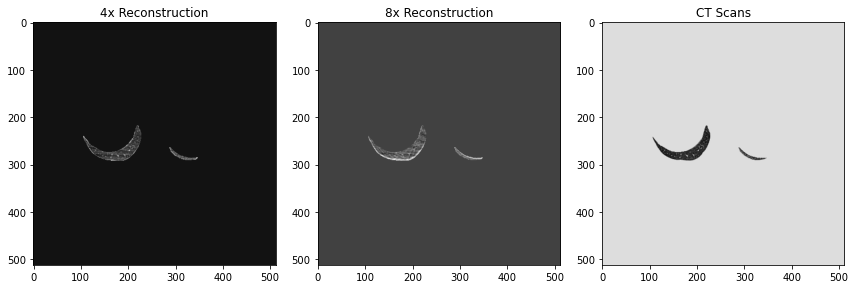

In [14]:
plt.rcParams["figure.figsize"] = (12,12)
i = 19
f, axarr = plt.subplots(1,3)
axarr[0].set_title("4x Reconstruction")
axarr[0].imshow(reconstruct_4x.reconstructed_ct_scans[i], cmap='gray')
axarr[1].set_title("8x Reconstruction")
axarr[1].imshow(reconstruct_8x.reconstructed_ct_scans[i], cmap='gray')
axarr[2].set_title("CT Scans")
axarr[2].imshow(ct_scans[i], cmap='gray')
f.tight_layout()
plt.show()

Evaluating Segmentation on 4x and 8x Reconstruction

Processing Image 19Time Taken =  9.557435536757112


IndexError: index 99 is out of bounds for axis 0 with size 20

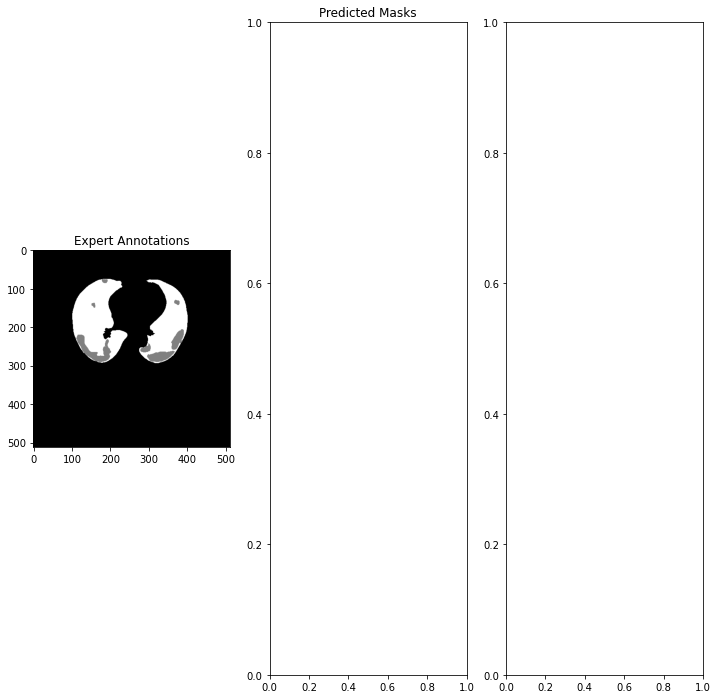

In [15]:
pred_masks_4x = get_predicted_mask(reconstruct_4x.reconstructed_ct_scans)
print("Evaluation Metrics for 4x Reconstruction")
find_eval_metrics(infection_masks, pred_masks_4x)

print()
print()
print()

pred_masks_8x = get_predicted_mask(reconstruct_8x.reconstructed_ct_scans)
print("Evaluation Metrics for 8x Reconstruction")
find_eval_metrics(infection_masks, pred_masks_8x)

**COMPLETED**